# Code to check the data records

# Setup

In [ ]:
import sys
import json
import os
import shutil
import pickle
import csv
import pandas as pd
import numpy as np
import copy
import time
from datetime import timedelta
from datetime import datetime
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# options for display setting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False) 

In [2]:
# change the dataset path
DATASET = '../EmoWork'

# META

## presurvey

In [3]:
META = os.path.join(DATASET, 'META')
general_information = 'meta.csv'
meta = pd.read_csv(os.path.join(META, general_information), index_col=None)

In [4]:
pre_survey = 'presurvey.csv'
demo = pd.read_csv(os.path.join(META,pre_survey), index_col=None)
display(demo.head(2))

# Simple statistic value on sex, education level, dominant hand, ages and career 
print('F = Female, M = Male')
print(demo['Sex'].value_counts().to_string(), '' ,sep='\n')

print('0 = high school, 1 = above bachelors degree')
print(demo['Education'].value_counts().to_string(), '' ,sep='\n')

print('0 = right hand, 1 = lef hand')
print(demo['Dominant hand'].value_counts().to_string(), '' ,sep='\n')

display(demo[['Age', 'Career']].describe())

,Pnum,Sex,Age,Education,Dominant hand,Career,PHQ-1,PHQ-2,PHQ-3,PHQ-4,PHQ-5,PHQ-6,PHQ-7,PHQ-8,PHQ-9,PSS-1,PSS-2,PSS-3,PSS-4,PSS-5,PSS-6,PSS-7,PSS-8,PSS-9,PSS-10,PPC-1,PPC-2,PPC-3,PPC-4,PPC-5,PPC-6,PPC-7,PPC-8,PPC-9,PPC-10,PPC-11,PPC-12,PPC-13,PPC-14,PPC-15,PPC-16,PPC-17,PPC-18,BFI-1,BFI-2,BFI-3,BFI-4,BFI-5,BFI-6,BFI-7,BFI-8,BFI-9,BFI-10,BFI-11,BFI-12,BFI-13,BFI-14,BFI-15,RSE-1,RSE-2,RSE-3,RSE-4,RSE-5,RSE-6,RSE-7,RSE-8,RSE-9,RSE-10,SWLS-1,SWLS-2,SWLS-3,SWLS-4,SWLS-5
0,1,1,43,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,2,0,0,3,4,3,4,4,2,4,4,5,4,4,5,3,4,4,4,4,3,3,3,4,4,3,3,1,1,2,3,3,3,3,3,3,3,3,1,3,3,3,3,3,1,1,6,6,6,5,6
1,2,1,54,1,0,3,1,1,2,1,0,2,0,0,0,2,1,2,3,3,1,2,1,1,2,4,4,4,4,4,3,5,5,5,4,4,5,4,5,4,4,2,4,4,4,4,4,4,4,3,2,5,3,4,2,4,4,4,3,2,2,4,3,3,3,2,2,2,5,5,5,5,4


F = Female, M = Male
1    24
0     7

0 = high school, 1 = above bachelors degree
0    19
1    12

0 = right hand, 1 = lef hand
0    30
1     1



,Age,Career
count,31.000000,31.000000
mean,36.193548,3.290323
std,11.379570,2.492570
min,19.000000,0.000000
25%,26.500000,1.000000
50%,34.000000,3.000000
75%,46.500000,4.000000
max,54.000000,10.000000


In [5]:
def compute_score_and_level(df, prefix, bins, labels):
    cols = df.columns[df.columns.str.startswith(prefix)]
    
    df[f'{prefix}_total'] = df[cols].sum(axis=1)
    df[f'{prefix}_level'] = pd.cut(df[f'{prefix}_total'], bins=bins, labels=labels)
    
    print(f"{prefix} level distribution:")
    print(df[f'{prefix}_level'].value_counts().sort_index().to_string())

In [6]:
# Simple statistic value on baseline status 
# 1. PHQ-9 (https://med.stanford.edu/fastlab/research/imapp/msrs/_jcr_content/main/accordion/accordion_content3/download_256324296/file.res/PHQ9%20id%20date%2008.03.pdf)
demo_new = demo.copy()
demo_new['PHQ_total'] = demo.filter(like='PHQ', axis=1).sum(axis=1)
demo_new['PHQ_level'] = pd.cut(demo_new['PHQ_total'], bins=[-float('inf'), 4, 9, 14, 19, float('inf')], labels=['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5'])

# Group 1 = no depression, Group 2: light depression, Group 3: Moderate depression, Group 4: Moderately severe Depression, Group 5 ; Severe depression
print(demo_new['PHQ_level'].value_counts().sort_index().to_string())
print('\nModerate depreesion:', demo_new[demo_new['PHQ_level']=='Group 3']['Pnum'].values, '\n')

#2. PSS (https://www.das.nh.gov/wellness/docs/percieved%20stress%20scale.pdf)
demo_new['PSS_total'] = demo.filter(like='PSS', axis=1).sum(axis=1)
demo_new['PSS_level'] = pd.cut(demo_new['PSS_total'], bins=[-float('inf'), 13, 26, float('inf')], labels=['Group 1', 'Group 2', 'Group 3'])

# Group 1 = low stress, Group 2: moderate stress, Group 3: high stress
print(demo_new['PSS_level'].value_counts().sort_index().to_string())
print('\nHigh stress:', demo_new[demo_new['PSS_level']=='Group 3']['Pnum'].values, '\n')

#3. PPC 
# print(demo.iloc[:, 25:43].columns)

#4. BFI-15  
# print(demo.iloc[:, 43:58].columns)
print('BFI-15 distribution (5 likert scale)')
print(demo.filter(like='BFI', axis=1).describe().loc[['count','mean','std']],'\n')

#5. RSE (https://wwnorton.com/college/psych/psychsci/media/rosenberg.html)
rse_columns = demo.columns[demo.columns.str.startswith('RSE')]

def transform_value(value, reverse=False):
    return value - 1 if not reverse else 3 - (value - 1)

# Transform values and calculate the sum to compute 'RSE_total'
demo_new['RSE_total'] = demo[rse_columns].apply(
    lambda row: sum(
        transform_value(row[col], reverse=(col not in ['RSE-1', 'RSE-2', 'RSE-4', 'RSE-6', 'RSE-7']))
        for col in rse_columns
    ), axis=1
)
demo_new['RSE_level'] = pd.cut(demo_new['RSE_total'], bins=[-float('inf'), 14, 25, float('inf')], labels=['Group 1', 'Group 2', 'Group 3'])

# Group 1 = low, Group 2 = Normal, Group 3 = above normal
print(demo_new['RSE_level'].value_counts().sort_index().to_string())
print('\nLow self-esteem:', demo_new[demo_new['RSE_level'] == 'Group 1']['Pnum'].values)
print('Above normal self-esteem:', demo_new[demo_new['RSE_level'] == 'Group 3']['Pnum'].values, '\n')

# 6. SWLS (https://link.springer.com/referenceworkentry/10.1007/978-94-007-0753-5_2576 )
demo_new['SWLS_total'] = demo.filter(like='SWLS', axis=1).sum(axis=1)
demo_new['SWLS_level'] = pd.cut(demo_new['SWLS_total'], bins=[-float('inf'), 9, 14, 19, 24, 29, float('inf')], labels=['Group 1', 'Group 2', 'Group 3', 'Group 4','Group 5', 'Group 6'])

# Group 1 = extremely dissatisfied, Group 2: dissatisfied, Group 3: below average, Group 4: average range, Group 5: high, Group 6 : very high
print(demo_new['SWLS_level'].value_counts().sort_index().to_string())
print('\nExtremely dissatisfied:', demo_new[demo_new['SWLS_level']=='Group 1']['Pnum'].values)
print('Dissatisfied:', demo_new[demo_new['SWLS_level']=='Group 2']['Pnum'].values, '\n')

Group 1    19
Group 2     9
Group 3     3
Group 4     0
Group 5     0

Moderate depreesion: [ 5 21 29] 

Group 1    10
Group 2    18
Group 3     3

High stress: [ 9 24 28] 

BFI-15 distribution (5 likert scale)
           BFI-1      BFI-2      BFI-3      BFI-4      BFI-5      BFI-6      BFI-7      BFI-8      BFI-9     BFI-10     BFI-11     BFI-12     BFI-13     BFI-14     BFI-15
count  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000  31.000000
mean    2.903226   2.838710   3.580645   3.548387   3.516129   3.774194   2.483871   1.967742   3.451613   2.806452   3.032258   2.935484   3.677419   3.419355   3.225806
std     1.135924   1.319009   1.176837   0.994609   1.028623   1.023383   1.150970   0.982645   1.337627   1.275914   1.303428   1.364685   0.871286   0.992445   1.023383 

Group 1     4
Group 2    22
Group 3     5

Low self-esteem: [ 5 11 24 29]
Above normal self-esteem: [ 4

In [7]:
# order_type 1 means normal - shouting - swearing, order_type 0 meanse normal - swearing - shouting
meta 

,Pnum,order_type,actor,actor_sex
0,1.0,1.0,1.0,M
1,2.0,0.0,1.0,M
2,3.0,1.0,1.0,M
3,4.0,0.0,1.0,M
4,5.0,0.0,1.0,M
5,6.0,0.0,1.0,M
6,7.0,0.0,1.0,M
7,8.0,1.0,1.0,M
8,9.0,0.0,1.0,M
9,10.0,0.0,1.0,M


# LABELS

In [22]:
LABELS = os.path.join(DATASET, 'LABELS')
label = os.path.join(LABELS, 'label.pkl')

with open(label, 'rb') as f:
  LABEL = pickle.load(f)

In [23]:
def plot_single_participant(pnum, participant_data):
    fig, axes = plt.subplots(1, 4, figsize=(40, 5))
    measures = [
        ('valence', 'Valence', (0, 10)),
        ('arousal', 'Arousal', (0, 10)),
        ('stress', 'Stress', (0, 21)),
        ('suppression', 'Suppression', (0, 21))
    ]

    for i, (measure, ylabel, ylim) in enumerate(measures):
        ax = axes[i]
        for condition in ['c1', 'c2', 'c3']:
            if condition in participant_data:
                condition_data = participant_data[condition]
                if condition_data:
                    measure_data = condition_data.get(measure, {})
                    timestamp = measure_data['Timestamp']
                    values = measure_data[measure]
                    if len(timestamp) > 0 and len(values) > 0:
                        ax.plot(timestamp, values, label=f'{condition.capitalize()} {ylabel}', alpha=0.7)

        ax.set_xlabel('Timestamp')
        ax.set_ylabel(ylabel)
        ax.set_ylim(*ylim)
        ax.set_title(f'{ylabel} over Time for Participant {pnum}')
        ax.legend()
        # ax.grid(True)

    plt.tight_layout()
    plt.show()


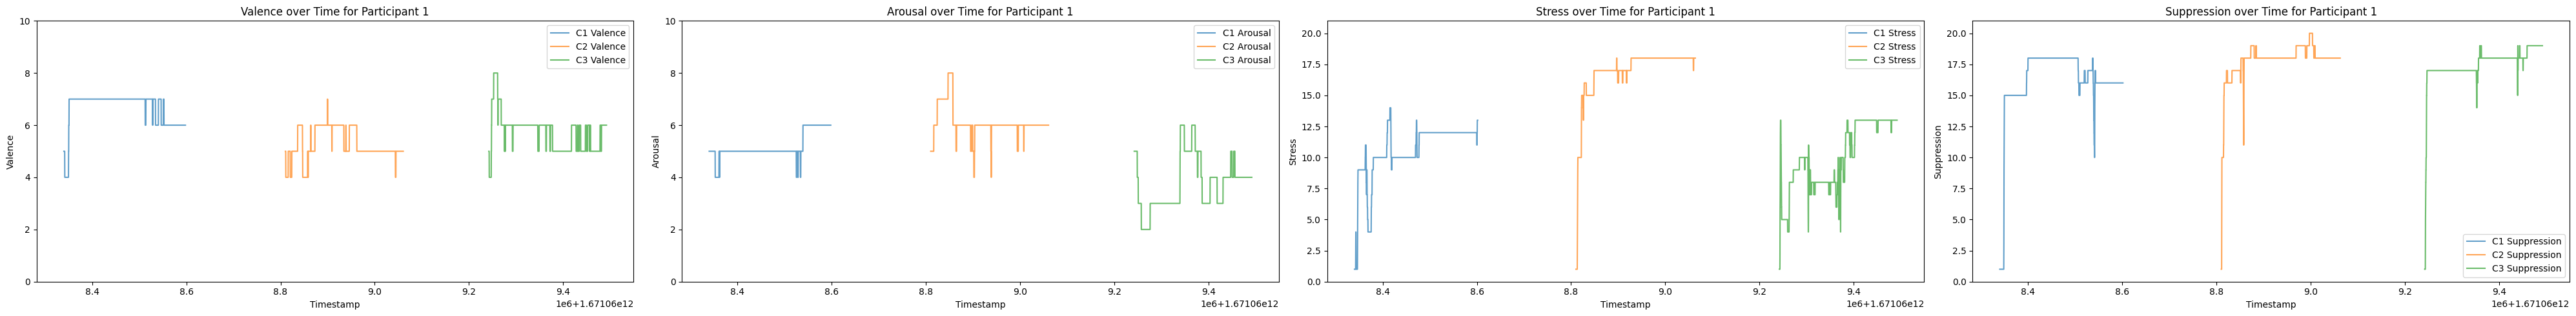

In [25]:
# Visualize all label data for each participant
# for pnum, participant_data in LABEL.items():
#     plot_participant_label(pnum, participant_data)

plot_single_participant(1, LABEL[1])

# SENSORS_visualization

In [28]:
SENSORS = os.path.join(DATASET, 'SENSORS')
sensors = os.path.join(SENSORS, 'sensors.pkl')

with open(sensors, 'rb') as f:
  SENSORS = pickle.load(f)

In [57]:
def plot_combined_sessions(DATA, pnum, sensor_name):
    sessions = DATA[pnum] 
    
    first_session = next((sensors[sensor_name] for session, sensors in sessions.items() if sensor_name in sensors), None)
    if first_session is None:
        print(f"Sensor '{sensor_name}' not found for Participant {pnum}.")
        return

    if "Timestamp" not in first_session.columns:
        print(f"'Timestamp' column missing in '{sensor_name}' data.")
        return

    sensor_columns = [col for col in first_session.columns if col != "Timestamp"] 

    num_subplots = len(sensor_columns)
    fig, axes = plt.subplots(num_subplots, 1, figsize=(14, 2 * num_subplots), sharex=True, constrained_layout=False)

    if num_subplots == 1:
        axes = [axes]  

    for ax, col in zip(axes, sensor_columns):
        for session, sensors in sessions.items():  
            if sensor_name not in sensors:
                continue  
            df = sensors[sensor_name]  # Convert sensor data to a DataFrame
            if "Timestamp" not in df.columns:
                continue  # Skip if 'Timestamp' column is missing

            ax.plot(df["Timestamp"], df[col], label=f"{session} - {col}")
            ax.set_ylabel(col)
            ax.legend(loc="upper right", fontsize=8)
            ax.grid(True)

    plt.xlabel("Timestamp")
    # plt.suptitle(f"Participant {pnum} - {sensor_name} Across Sessions", fontsize=14)
    axes[0].set_title(f"Participant {pnum} - {sensor_name} Across Sessions", fontsize=14)
    plt.show()

In [58]:
pnums = SENSORS.keys()
pnums

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

## MUSE

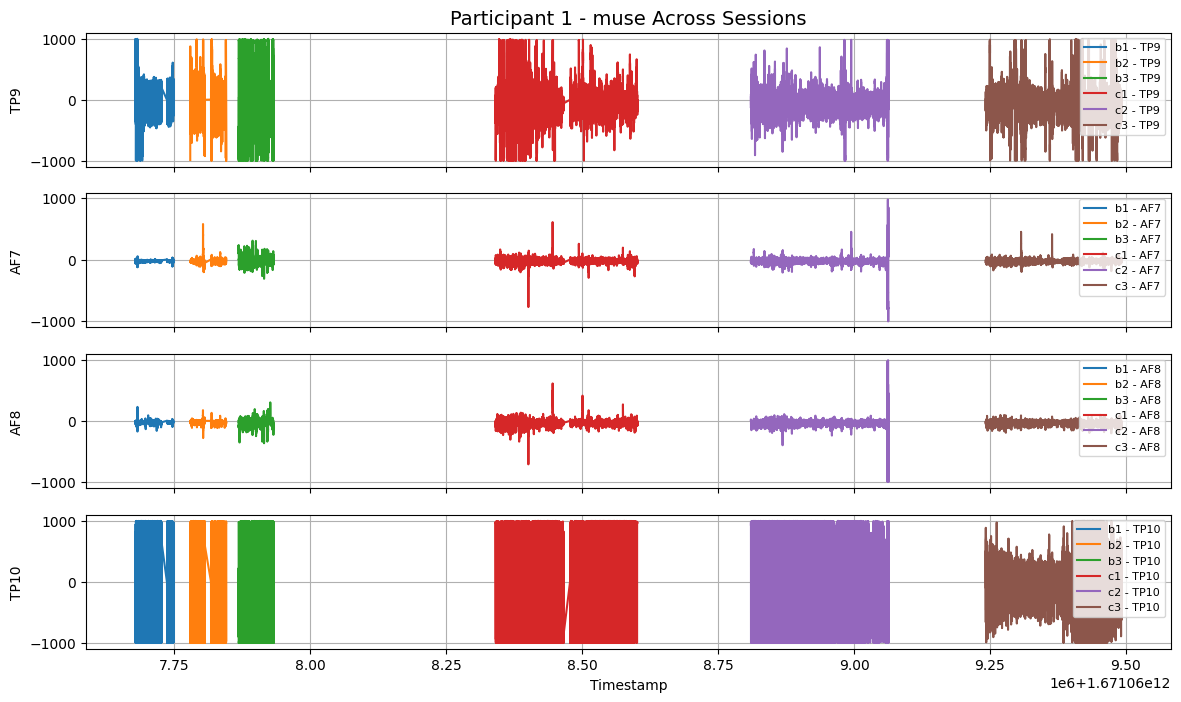

In [59]:
pnums = SENSORS.keys()
# Example execution: Visualize 'muse' sensor data for a specific participant (1)

# Run the below code for all participants
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "muse")

plot_combined_sessions(SENSORS, 1, "muse")

## E4_ACC

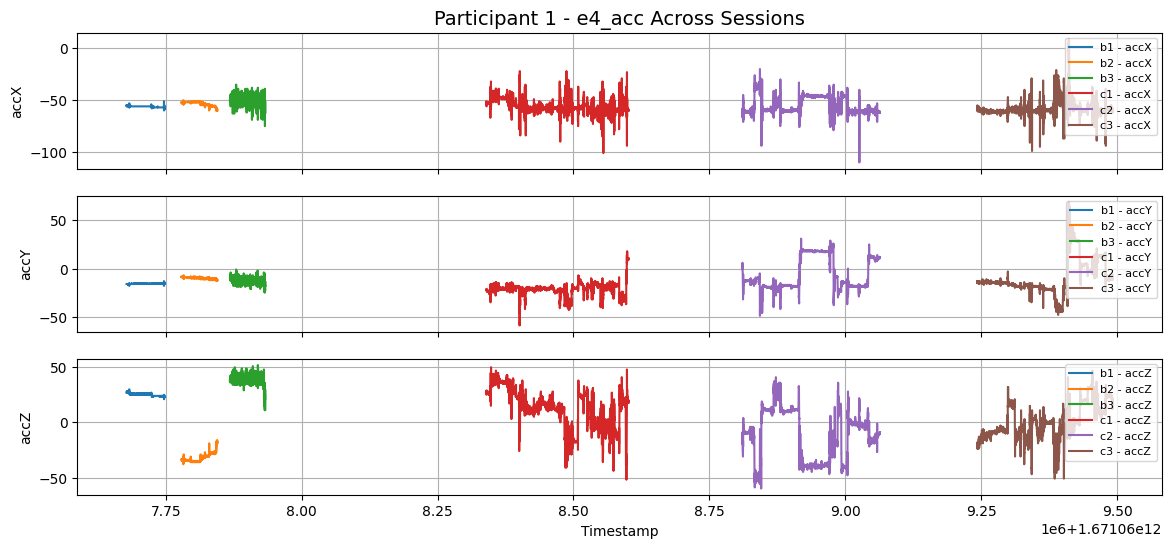

In [60]:
pnums = SENSORS.keys()
# Example execution: Visualize 'e4_acc' sensor data for all participants
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "e4_acc")

plot_combined_sessions(SENSORS, 1, "e4_acc")

## E4_BVP

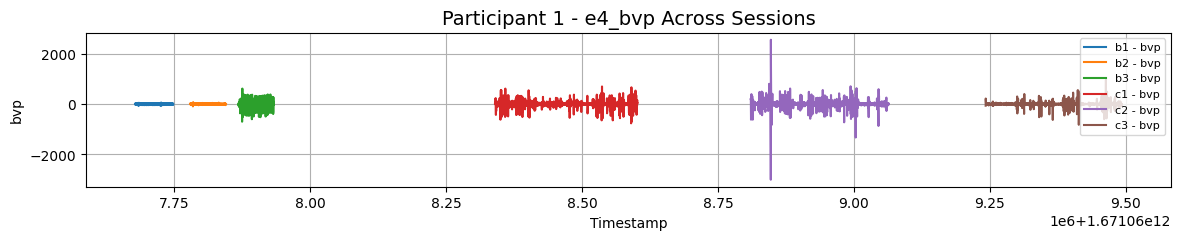

In [61]:
pnums = SENSORS.keys()
# Example execution: Visualize 'e4_bvp' sensor data for all participants
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "e4_bvp")

plot_combined_sessions(SENSORS, 1, "e4_bvp")

## E4_EDA

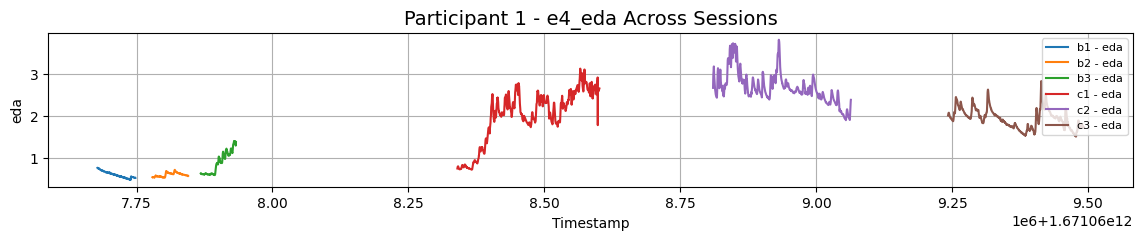

In [62]:
pnums = SENSORS.keys()
# Example execution: Visualize 'e4_eda' sensor data for a specific participant (1)
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "e4_eda")

plot_combined_sessions(SENSORS, 1, "e4_eda")

## E4_IBI

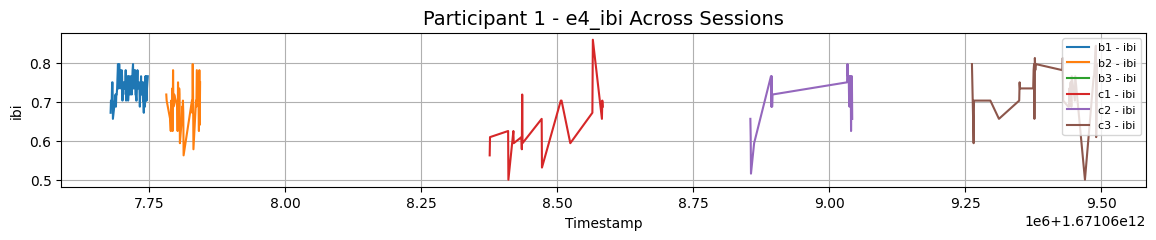

In [63]:
pnums = SENSORS.keys()
# Example execution: Visualize 'e4 ibi' sensor data for a specific participant (1)
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "e4_ibi")

plot_combined_sessions(SENSORS, 1, "e4_ibi")

## E4_temp

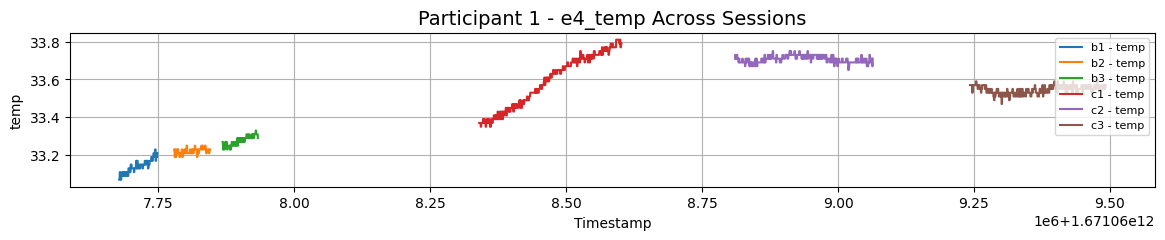

In [64]:
pnums = SENSORS.keys()
# Example execution: Visualize 'e4 temp' sensor data for a specific participant (1)
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "e4_temp")

plot_combined_sessions(SENSORS, 1, "e4_temp")

## polar_ecg

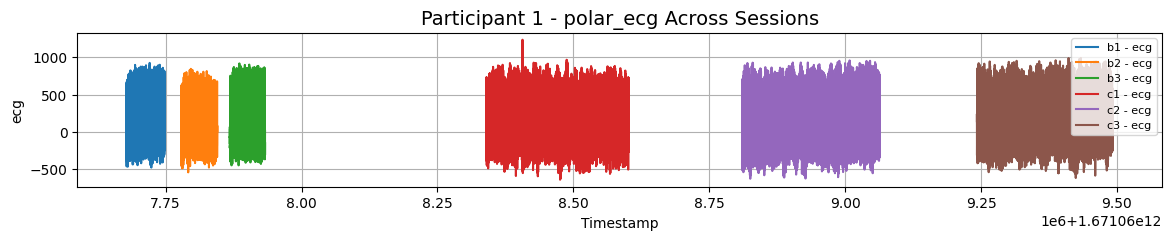

In [65]:
pnums = SENSORS.keys()
# Example execution: Visualize 'polar_ecg' sensor data for a specific participant (1)
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "polar_ecg")

plot_combined_sessions(SENSORS, 1, "polar_ecg")

## polar_hr

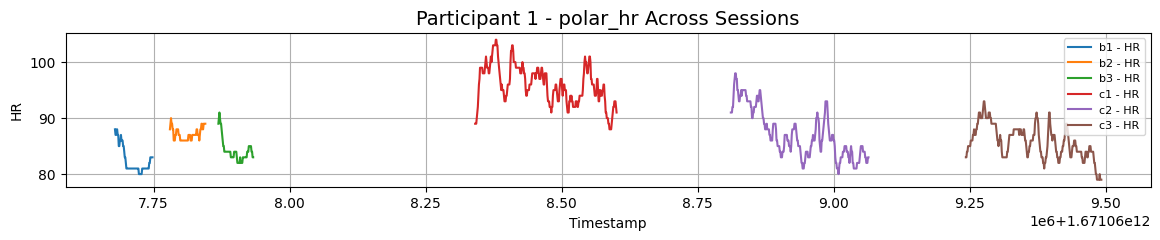

In [66]:
pnums = SENSORS.keys()
# Example execution: Visualize 'polar_hr' sensor data for a specific participant (1)
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "polar_hr")

plot_combined_sessions(SENSORS, 1, "polar_hr")

## polar_rr

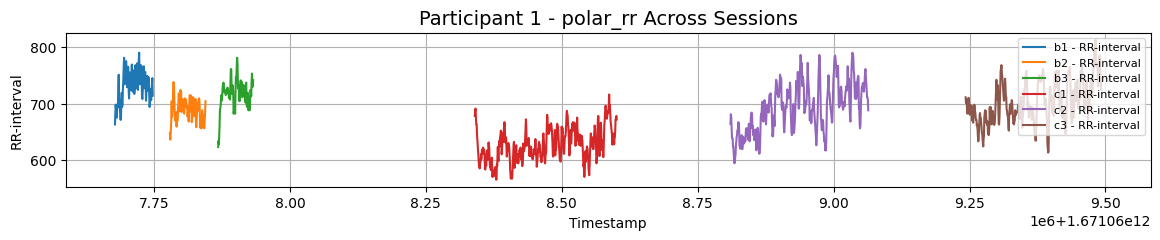

In [67]:
pnums = SENSORS.keys()
# Example execution: Visualize 'polar_rr' sensor data for a specific participant (1)
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "polar_rr")

plot_combined_sessions(SENSORS, 1, "polar_rr")

## galaxy_ppg

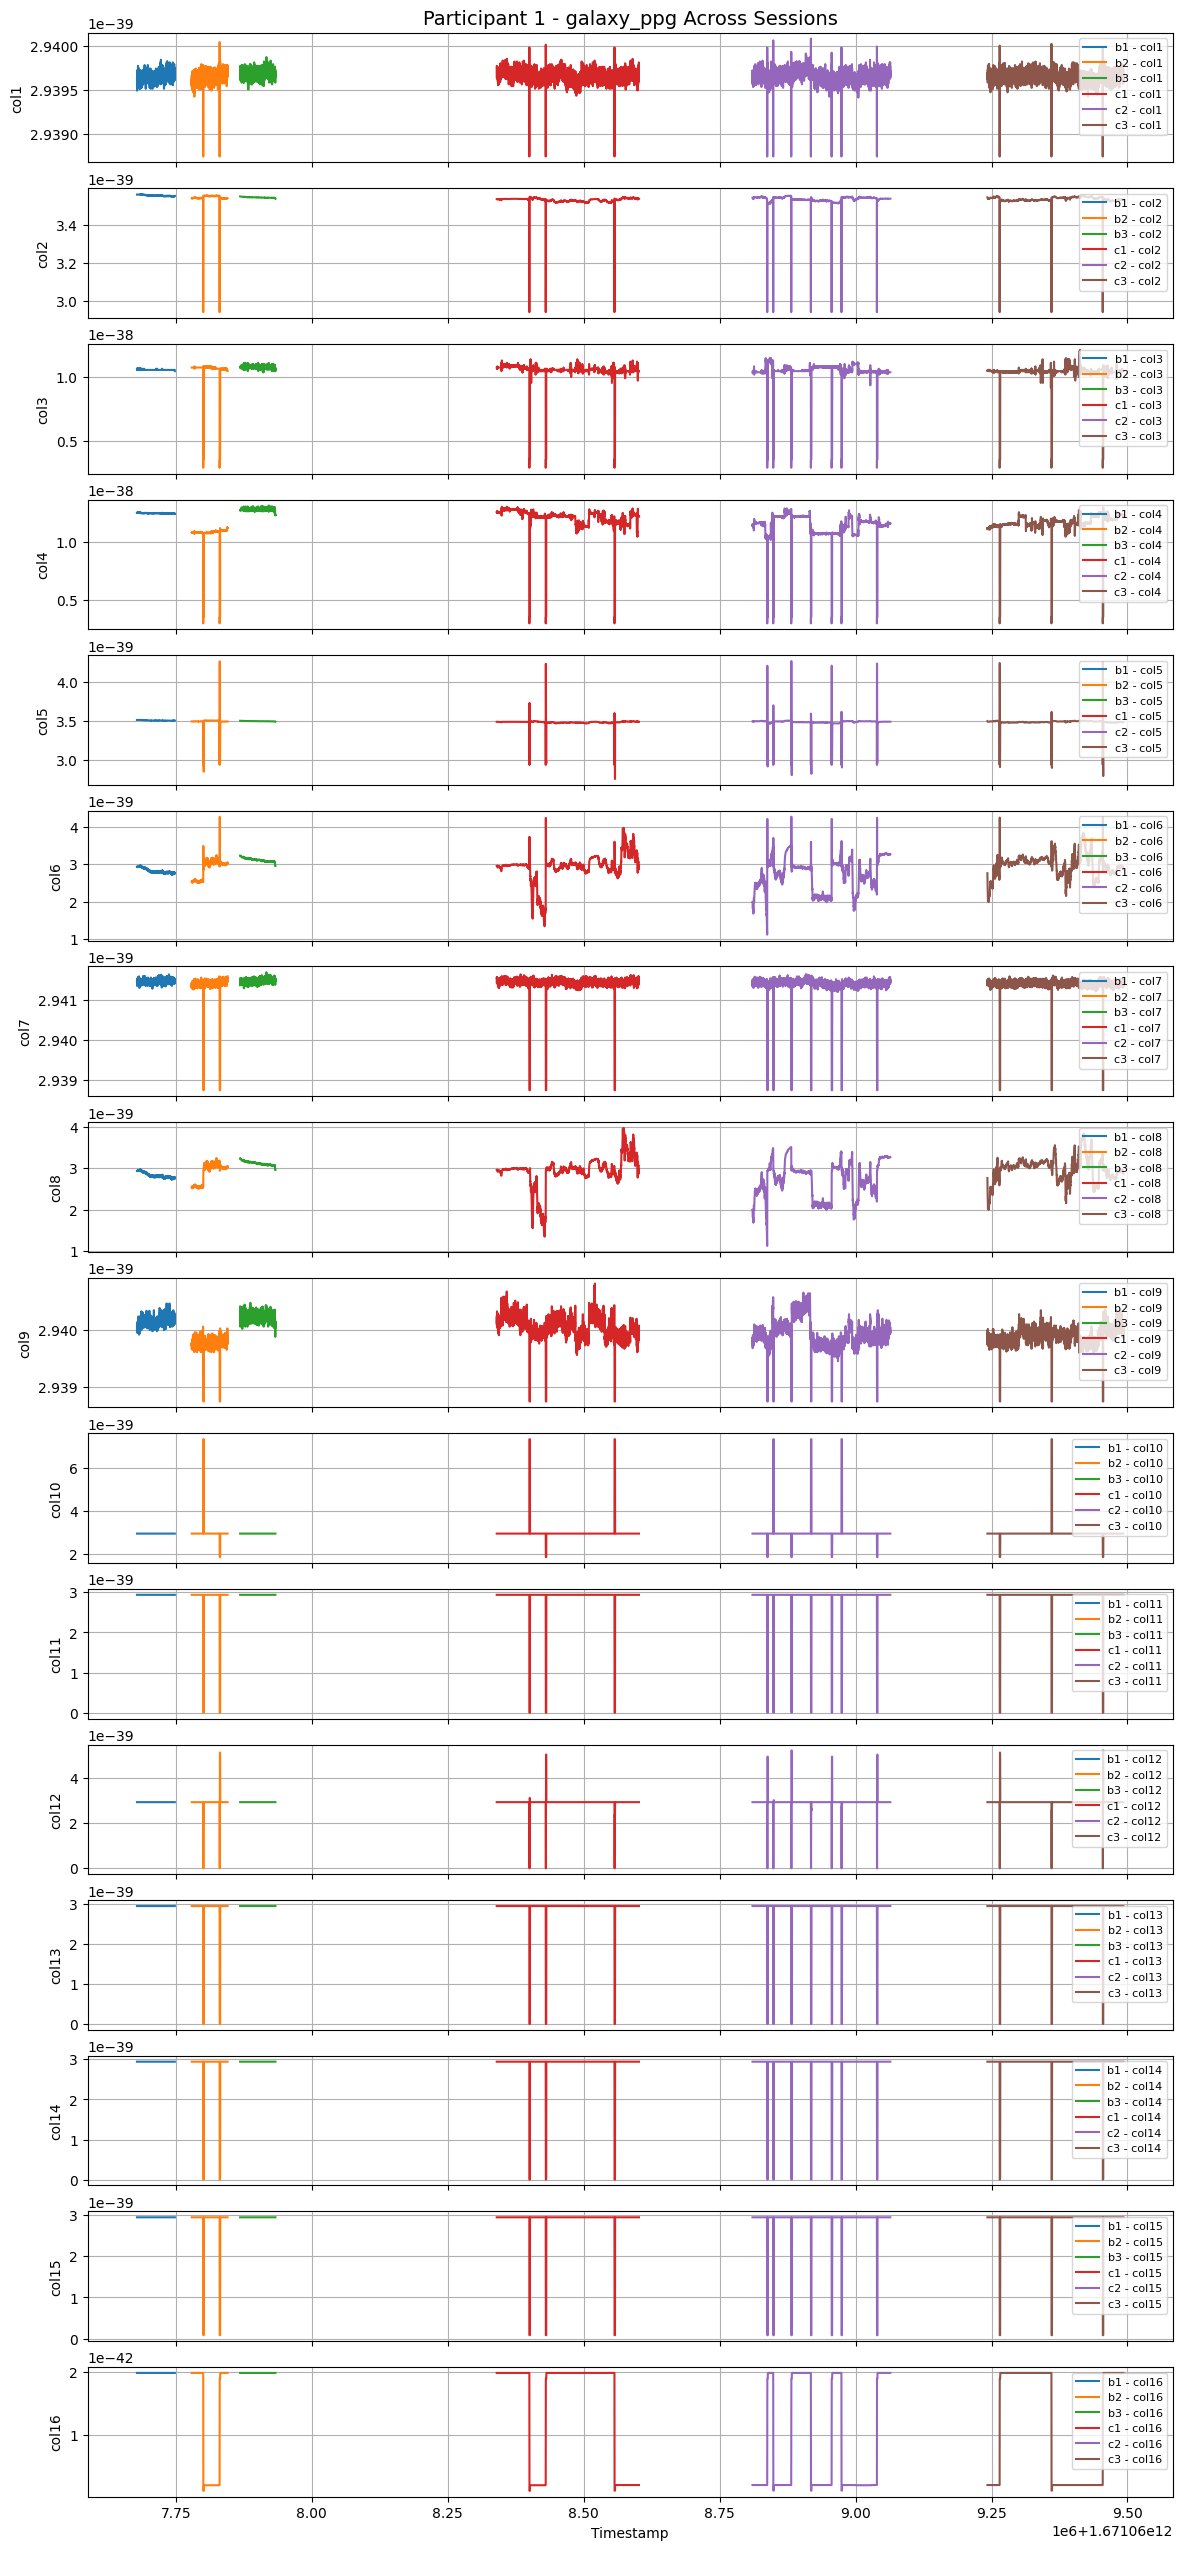

In [68]:
pnums = SENSORS.keys()
# Example execution: Visualize 'galaxy_acc' sensor data for a specific participant (1)
# for i in pnums:
#     plot_combined_sessions(SENSORS, i, "galaxy_ppg")

plot_combined_sessions(SENSORS, 1, "galaxy_ppg")

# SENSORS_data quality

## Check amount of data

In [69]:
def check (DATA, sensor_type, frequency):
    total_data_points = 0
    total_expected_points = 0
    total_duplicate_groups = 0  # Total count of duplicate groups


    threshold = (1 / frequency) * 1000  # Expected interval in seconds
    print(f"Threshold : {threshold} mili-seconds")

    for pnum, sessions in DATA.items():  
        for session, DATA in sessions.items():  
            if sensor_type not in DATA:
                print(f"Sensor '{sensor_type}' not found for Participant {pnum}, Session {session}")
                continue 
            
            df = DATA[sensor_type]
            if "Timestamp" not in df.columns or len(df) < 2:
                print(f"Insufficient data for Participant {pnum}, Session {session}")
                continue

            # Calculate total duration and expected data points
            min_time = df["Timestamp"].min()/1000 
            max_time = df["Timestamp"].max()/1000
            duration = max_time - min_time
            expected_points = round(duration * frequency)

            # Calculate actual data points
            actual_points = len(df)

            # Calculate time differences
            df["TimeDiff"] = df["Timestamp"].diff().dropna()  # Time differences in milliseconds

            # Calculate max and min intervals
            max_interval = df["TimeDiff"].max()
            min_interval = df["TimeDiff"].min()

            # check interval 
            if round(max_interval) > round(threshold) : 
                print(f"{pnum},{session}, Max interval: {max_interval:} milliseconds")
            if min_interval == 0 : 
                #print(f"{pnum},{session}, Min interval: {min_interval:} milliseconds")
                duplicated_timestamps = df.loc[df["Timestamp"].duplicated(keep=False), "Timestamp"]

                #duplicated_timestamps = df[df["Timestamp"].duplicated(keep=False)]
                if not duplicated_timestamps.empty:
                    # Each duplicated value is counted as one group (based on unique values)
                    unique_dups = duplicated_timestamps.unique()
                    duplicate_group_count = len(unique_dups)
                    total_duplicate_groups += duplicate_group_count
                    print(f"Duplicated Timestamps for {pnum}, {session} (group count): {duplicate_group_count}")
                    # Optionally, print duplicated values as full numbers:
                    for ts in unique_dups:
                        print(int(ts))
                else:
                    print(f"No duplicated Timestamps for {pnum}, {session}")

            # Update totals
            total_data_points += actual_points
            total_expected_points += expected_points

            # Calculate missing data
            missing_points = expected_points - actual_points

    # Calculate overall statistics
    if total_expected_points > 0:
        missing_ratio = ((total_expected_points - total_data_points) / total_expected_points) * 100
    else:
        missing_ratio = 0

    print(f"Total expected data points: {total_expected_points}")
    print(f"Total actual data points: {total_data_points}")
    print(f"Overall missing data ratio: {missing_ratio:.2f}%")
    print(f"Total duplicated Timestamp groups: {total_duplicate_groups}")
    return

In [70]:
check(SENSORS, "muse", frequency=256)

Threshold : 3.90625 mili-seconds
1,b1, Max interval: 10299.0 milliseconds
Duplicated Timestamps for 1, b1 (group count): 2
1671067736382
1671067736421
1,b2, Max interval: 11019.0 milliseconds
Duplicated Timestamps for 1, b2 (group count): 3
1671067817229
1671067817265
1671067817335
1,c1, Max interval: 11503.0 milliseconds
Duplicated Timestamps for 1, c1 (group count): 1
1671068477810
1,c2, Max interval: 5.0 milliseconds
1,c3, Max interval: 6.0 milliseconds
2,b1, Max interval: 5.0 milliseconds
2,c1, Max interval: 5.0 milliseconds
2,c2, Max interval: 6.0 milliseconds
2,c3, Max interval: 8.0 milliseconds
3,b1, Max interval: 5.0 milliseconds
3,b2, Max interval: 5.0 milliseconds
3,b3, Max interval: 5.0 milliseconds
3,c1, Max interval: 5.0 milliseconds
3,c2, Max interval: 5.0 milliseconds
3,c3, Max interval: 5.0 milliseconds
4,b1, Max interval: 5.0 milliseconds
4,b2, Max interval: 5.0 milliseconds
4,b3, Max interval: 5.0 milliseconds
4,c1, Max interval: 5.0 milliseconds
4,c2, Max interval: 5

In [71]:
check(SENSORS, "e4_bvp", frequency=64)

Threshold : 15.625 mili-seconds
Insufficient data for Participant 25, Session b2
Total expected data points: 2235616
Total actual data points: 2235706
Overall missing data ratio: -0.00%
Total duplicated Timestamp groups: 0


In [72]:
check(SENSORS, "e4_eda", frequency=4)

Threshold : 250.0 mili-seconds
Insufficient data for Participant 25, Session b2
Total expected data points: 139549
Total actual data points: 139734
Overall missing data ratio: -0.13%
Total duplicated Timestamp groups: 0


In [73]:
check(SENSORS, "e4_temp", frequency=4)

Threshold : 250.0 mili-seconds
Insufficient data for Participant 25, Session b2
Total expected data points: 139545
Total actual data points: 139730
Overall missing data ratio: -0.13%
Total duplicated Timestamp groups: 0


In [74]:
check(SENSORS, "e4_acc", frequency=32)

Threshold : 31.25 mili-seconds
Insufficient data for Participant 25, Session b2
Total expected data points: 1117663
Total actual data points: 1117848
Overall missing data ratio: -0.02%
Total duplicated Timestamp groups: 0


In [75]:
check(SENSORS, "polar_ecg", frequency=130)

Threshold : 7.6923076923076925 mili-seconds
Total expected data points: 4557166
Total actual data points: 4556459
Overall missing data ratio: 0.02%
Total duplicated Timestamp groups: 0


In [76]:
check(SENSORS, "galaxy_ppg", frequency= 25)

Threshold : 40.0 mili-seconds
1,b1, Max interval: 50.999755859375 milliseconds
1,b2, Max interval: 49.0 milliseconds
1,b3, Max interval: 336.0 milliseconds
1,c1, Max interval: 52.0 milliseconds
1,c2, Max interval: 66.0 milliseconds
1,c3, Max interval: 54.000244140625 milliseconds
2,b1, Max interval: 52.0 milliseconds
2,b2, Max interval: 50.0 milliseconds
2,b3, Max interval: 54.0 milliseconds
2,c1, Max interval: 70.0 milliseconds
2,c2, Max interval: 109.0 milliseconds
2,c3, Max interval: 51.0 milliseconds
3,b1, Max interval: 51.0 milliseconds
3,b2, Max interval: 71.000244140625 milliseconds
3,b3, Max interval: 51.0 milliseconds
3,c1, Max interval: 51.0 milliseconds
3,c2, Max interval: 91.0 milliseconds
3,c3, Max interval: 50.0 milliseconds
4,b1, Max interval: 52.0 milliseconds
4,b2, Max interval: 53.0 milliseconds
4,b3, Max interval: 63.0 milliseconds
4,c1, Max interval: 64.0 milliseconds
4,c2, Max interval: 64.000244140625 milliseconds
4,c3, Max interval: 52.0 milliseconds
5,b1, Max in

## Check time interval 

In [ ]:
# interval(SENSORS, "polar_rr")

In [ ]:
# interval(SENSORS, "polar_hr")

In [ ]:
# interval(SENSORS, "e4_ibi")